# 2c: Create scenario parameters

## Plain English summary
We want to see the effect on the thrombolysis rate when we change certain parts of the patient pathway. This notebook sets up the numbers needed to perform those calculations. 

The scenario before we change anything is called "base". The hospital performance for this scenario was found in the previous notebook.

The three other scenario types we will consider are:
+ onset
+ speed
+ benchmark

In addition, any of the three scenario types can be considered simultaneously. The complete list of scenario combinations is as follows:
+ base
+ onset
+ speed
+ benchmark
+ onset + speed
+ onset + benchmark
+ speed + benchmark
+ onset + speed + benchmark

To set up the scenarios, we take the base hospital performance data and overwrite certain values to achieve some target results.

+ In the onset scenario, the proportion of patients with a known onset time is the greater of the current proportion and the national upper quartile.
+ In the speed scenario, 95% of patients have a scan within 4 hours of arrival, and all patients have 15 minutes arrival-to-scan time and 15 minutes scan-to-needle time.
+ In the benchmark scenario, the proportion of patients thrombolysed matches the benchmark rate found in the previous notebook. This rate is different for each hospital.

## Notebook setup:

In [1]:
import pandas as pd
import numpy as np
import pickle
from dataclasses import dataclass
import yaml

import matplotlib.pyplot as plt

import stroke_utilities.scenario as scenario

## Set up paths and filenames

In [2]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    output_folder = './stroke_utilities/output/'

paths = Paths()

## Import existing utilities

The hospital performance metrics were created in the notebook `03`.

Import the hospital performance:

In [3]:
df_hospital_performance = pd.read_csv(
    f'{paths.output_folder}/hospital_performance.csv',
    index_col='stroke_team_id'
    )

df_hospital_performance.head(6).T

stroke_team_id,1,1,1,1,2,2
stroke_type,lvo,nlvo,other,mixed,lvo,nlvo
admissions,79.4,223.8,40.2,343.4,87.8,325.0
proportion_of_all_with_ivt,0.244332,0.140304,0.0,0.147932,0.410023,0.122462
proportion_of_all_with_mt,0.04534,0.001787,0.0,0.011648,0.113895,0.005538
proportion_of_mt_with_ivt,0.444444,0.5,NaN,0.45,0.58,0.666667
proportion1_of_all_with_onset_known_ivt,0.513854,0.582663,0.512438,0.558532,0.492027,0.534154
proportion2_of_mask1_with_onset_to_arrival_on_time_ivt,0.823529,0.602761,0.757282,0.666319,0.898148,0.668203
proportion3_of_mask2_with_arrival_to_scan_on_time_ivt,0.982143,0.959288,0.974359,0.967136,1.0,0.943103
proportion4_of_mask3_with_onset_to_scan_on_time_ivt,0.951515,0.877984,0.947368,0.906149,0.974227,0.895795
proportion5_of_mask4_with_enough_time_to_treat_ivt,1.0,1.0,1.0,1.0,1.0,1.0


The benchmark thrombolysis rates were created in the notebook `02`.

Import the benchmark thrombolysis rates:

In [4]:
df_benchmark_codes = pd.read_csv(
    f'{paths.output_folder}/benchmark_rates_thrombolysis.csv',
    index_col='stroke_team_id'
    )

df_benchmark_codes

,Stroke type,Base,Benchmark,Base rate of mask5,Benchmark rate of mask5
stroke_team_id,,,,,
1,nlvo,0.114603,0.159889,0.389937,0.544025
1,lvo,0.216625,0.302267,0.547771,0.764331
1,other,0.000000,0.000000,0.000000,0.000000
1,mixed,0.128130,0.176471,0.392857,0.541071
2,nlvo,0.089410,0.135701,0.302575,0.459227
...,...,...,...,...,...
118,mixed,0.132290,0.157895,0.445509,0.531737
119,nlvo,0.165842,0.195545,0.475177,0.560284
119,lvo,0.369427,0.414013,0.773333,0.866667


In [5]:
with open('./stroke_utilities/fixed_params.yml') as f:
    fixed_params = yaml.safe_load(f)

In [1]:
fixed_params

NameError: name 'fixed_params' is not defined

In [7]:
# Set up allowed time and over-run for thrombolysis...
allowed_onset_to_needle_time_mins = fixed_params['allowed_onset_to_needle_time_mins']
allowed_overrun_for_slow_scan_to_needle_mins = fixed_params['allowed_overrun_for_slow_scan_to_needle_mins']
# ... and for thrombectomy
allowed_onset_to_puncture_time_mins = fixed_params['allowed_onset_to_puncture_time_mins']
allowed_overrun_for_slow_scan_to_puncture_mins = fixed_params['allowed_overrun_for_slow_scan_to_puncture_mins']
minutes_left = fixed_params['minutes_left']
# Limit for comparing conditions (e.g. is onset to arrival within
# 4hrs?). Separate limits for IVT and MT:
limit_ivt_mins = fixed_params['limit_ivt_mins']
limit_mt_mins = fixed_params['limit_mt_mins']

## Calculate onset scenario parameters

In [6]:
onset_time_known_proportion_upper_quantiles_dict = dict()

for stroke_type in ['lvo', 'nlvo', 'other', 'mixed']:
    mask = df_hospital_performance['stroke_type'] == stroke_type
    all_onset_time_known_proportion = (
        df_hospital_performance['proportion1_of_all_with_onset_known_ivt'][mask]
        )
    onset_time_known_proportion_upper_quantiles_dict[stroke_type] = (
        all_onset_time_known_proportion.quantile(0.75))

In [7]:
onset_time_known_proportion_upper_quantiles_dict

{'lvo': 0.608843,
 'nlvo': 0.5975165,
 'other': 0.6085775,
 'mixed': 0.6084415000000001}

## Define speed scenario parameters

The speed scenario parameters are the same for all teams:

In [8]:
# Overwrite original hospital performance with these values:
scenario_vals_dict = dict(
    lognorm_mu_arrival_scan_arrival_mins = np.log(15.0),
    lognorm_sigma_arrival_scan_arrival_mins = 1e-7,  # nearly zero.
    lognorm_mu_scan_needle_mins_ivt = np.log(15.0),
    lognorm_sigma_scan_needle_mins_ivt = 1e-7,       # nearly zero.
    arrival_to_scan_on_time_proportion = 0.95,
    )

For each team and stroke type, the onset and benchmark scenarios can be looked up individually.

## Example for one stroke team

The function in the following cell creates a column of data for each scenario and swaps in all of the relevant numbers.

In [9]:
stroke_team = df_hospital_performance.index[0]

df_performance_scenarios = scenario.build_scenario_hospital_performance(
    df_hospital_performance,
    stroke_team,
    scenario_vals_dict,
    onset_time_known_proportion_upper_quantiles_dict,
    df_benchmark_codes
)

View the resulting hospital performance data for just LVO patients. This is just because there's too much data to show all of the stroke types.

Some notes:
+ The index column has now changed from just the hospital name to the hospital name / stroke type / scenario.
+ Those three names are stored separately in the columns 'stroke_team', 'stroke_type', and 'scenario'.

In [10]:
df_performance_scenarios[df_performance_scenarios['stroke_type'] == 'lvo'].T

,1 / lvo / base,1 / lvo / benchmark,1 / lvo / onset,1 / lvo / speed,1 / lvo / onset + benchmark,1 / lvo / speed + benchmark,1 / lvo / speed + onset,1 / lvo / speed + onset + benchmark
stroke_type,lvo,lvo,lvo,lvo,lvo,lvo,lvo,lvo
admissions,79.4,79.4,79.4,79.4,79.4,79.4,79.4,79.4
proportion_of_all_with_ivt,0.244332,0.302267,0.256669,0.209535,0.358143,0.292374,0.248269,0.346422
proportion_of_all_with_mt,0.04534,0.035264,0.041783,0.033882,0.041783,0.033882,0.040145,0.040145
proportion_of_mt_with_ivt,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444,0.444444
proportion1_of_all_with_onset_known_ivt,0.513854,0.513854,0.608843,0.513854,0.608843,0.513854,0.608843,0.608843
proportion2_of_mask1_with_onset_to_arrival_on_time_ivt,0.823529,0.823529,0.823529,0.823529,0.823529,0.823529,0.823529,0.823529
proportion3_of_mask2_with_arrival_to_scan_on_time_ivt,0.982143,0.982143,0.982143,0.95,0.982143,0.95,0.95,0.95
proportion4_of_mask3_with_onset_to_scan_on_time_ivt,0.951515,0.951515,0.951515,0.951515,0.951515,0.951515,0.951515,0.951515
proportion5_of_mask4_with_enough_time_to_treat_ivt,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Plot the changing thrombolysis rate with scenario for this example team:

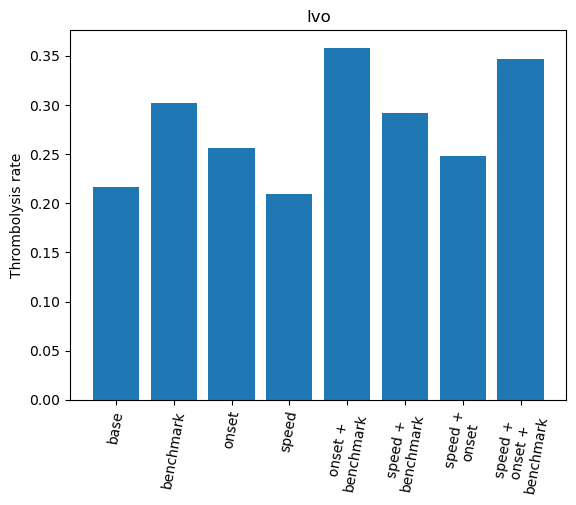

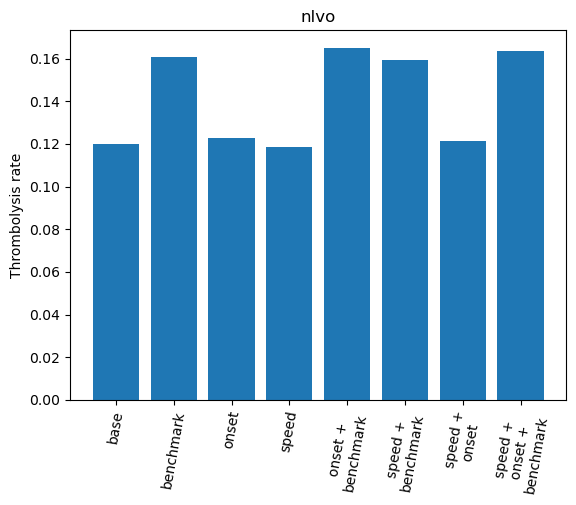

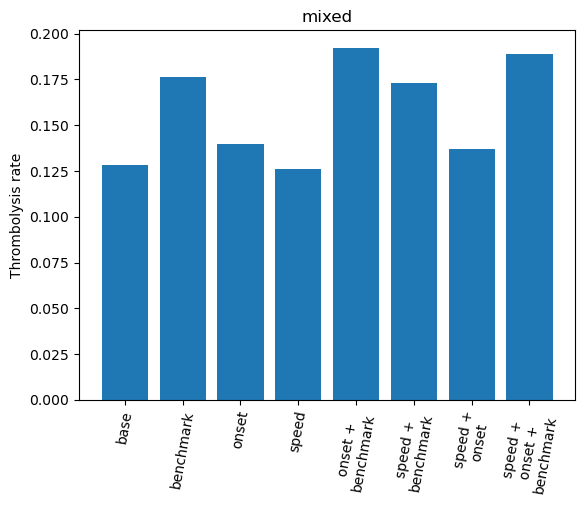

In [11]:
for stroke_type in ['lvo', 'nlvo', 'mixed']:
    ivt_rates = df_performance_scenarios[
        df_performance_scenarios['stroke_type'] == stroke_type][
        'proportion_of_all_with_mask6_and_ivt'
        ]
    ivt_labels = [i.split(f'1 / {stroke_type} / ')[1] 
                  for i in ivt_rates.index]
    ivt_labels = [' +\n'.join(i.split(' + ')) for i in ivt_labels]
    
    fig, ax = plt.subplots()
    ax.bar(np.arange(8), ivt_rates)
    ax.set_ylabel('Thrombolysis rate')
    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(ivt_labels, rotation=80)
    ax.set_title(stroke_type)
    plt.show()

## Create data for all stroke teams

Do the same process for all teams.

In [12]:
stroke_teams = sorted(list(set(df_hospital_performance.index)))

for s, stroke_team in enumerate(stroke_teams):

    df_performance_scenarios = scenario.build_scenario_hospital_performance(
        df_hospital_performance,
        stroke_team,
        scenario_vals_dict,
        onset_time_known_proportion_upper_quantiles_dict,
        df_benchmark_codes
    )
    # Store this data in the results dataframe.
    if s == 0:
        df_all_performance_scenarios = df_performance_scenarios.copy().T
    else:
        # Combine the two Series into a single DataFrame:
        df_all_performance_scenarios = pd.merge(
            df_all_performance_scenarios, df_performance_scenarios.T,
            right_index=True, left_index=True)

Save the results to file:

In [13]:
df = df_all_performance_scenarios.T

# Round the values to fewer decimal places:
for column in df.columns:
    if column not in ['stroke_team', 'stroke_type',
                      'stroke_team_id', 'scenario']:
        df[column] = df[column].astype(float).round(6)
        
df.to_csv(
    f'{paths.output_folder}/all_performance_scenarios.csv',
    index=True
    )